# 3. HPO (hyperparameters optimization)
Baysian optimization is used to evaluate best hyperparameters for different models. Baysian - roughly means that all hyperparameters are indipendent of each other (this is not exactly true, but is often a good, working, and robust approximaton). Baysian optimization works better than random and grid search for expensive computations, because additional cost for calculation of better hyperparameters optimization space is negligable. Otherwize (if the calculation of the main function is inexpensive), it is better to use Randon search or even Grid search. Good descriptions and examples can be found here: https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20%20GBDT%20workshop.ipynb.

### Different libraries exist for HPO:
- Scikit-Optimize
- Hyperopt
- Optuna
- hpbandster
- BayesianOptimization
- Sherpa
- SMAC3

Scikit-Optimize (https://github.com/scikit-optimize/scikit-optimize) is used here, thanks to this review comparison: (https://towardsdatascience.com/hyperparameter-optimization-in-python-part-0-introduction-c4b66791614b), where Scikit-Optimize wins against Hyperopt:
- Scikit-Optimize (https://towardsdatascience.com/hyperparameter-optimization-in-python-part-1-scikit-optimize-754e485d24fe) 
- Hyperopt        (https://towardsdatascience.com/hyperparameter-optimization-in-python-part-2-hyperopt-5f661db91324)  

### Different optimizers can be used by Bayesian optimization (https://scikit-optimize.github.io/#skopt.dump):
- dummy_minimize - which is a random search - just for comparison
- gp_minimize: Gaussian Process optimizer works best on gaussian-like parameters with a (not-very-big) parameters space.
- gbrt_mininize: Tree-based process - works best on high-dimensionality space, especially, if the parameters belong to different types, e.g. one parameter is integer, second is float, third is categorical, etc. (https://www.youtube.com/watch?v=DGJTEBt0d-s from 21:00). This is often the case, when we do not know very well our models and try very different parameters to tune for better performance.
- forest_minimize: Sequential optimisation using decision trees.

Good example and description can be found here: https://neptune.ml/blog/scikit-optimize. In this example forest_minimize showed better results than gp or gbrt.  
Good description of the parameters is avalible here: https://721-54340642-gh.circle-artifacts.com/0/tmp/circle-artifacts.kdXLWjd/api/minimize_functions.html

In [50]:
%reset -f 
#reset magic function allows one to release all previously used memory. -f (force) parameter allows to run it without confirmation from the user

%run libraries_and_functions

Libraries and functions loaded


In [51]:
# Load data
X = pd.read_pickle(r'088 solution/output/data/X_2_FE.pkl')

X_train = X[X.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = X[X.date_block_num < 33]['item_cnt_month']
X_val = X[X.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = X[X.date_block_num == 33]['item_cnt_month']
X_test = X[X.date_block_num == 34].drop(['item_cnt_month'], axis=1)

test = pd.read_csv('input/test.csv.gz') # used for submission

In [52]:
#Imort SKOPT 
import skopt

from skopt.space import Real, Integer

from skopt.utils import use_named_args

from skopt import gbrt_minimize, forest_minimize, gp_minimize

from skopt import dump, load

from skopt.plots import plot_convergence, plot_evaluations, plot_objective

from skopt.callbacks import CheckpointSaver, VerboseCallback # allows to save results for minimization function at each iteration (so do not loose if interrupted), Verbose is used to print verbosity - monitor progress

checkpoint_callback = CheckpointSaver(r'output/data/HPO_minimization_checkpoint_result.pkl') # Save current results at each iteration - will be used if run will not finish sucsessfully
verbose_callback = VerboseCallback(n_total=0) #starting point for the callback counter n_total

#Load the results from either last sucsessfully completed run or from checkpoint if the run was not finished successfully (e.g. was interrupted due to lack of time)
#res = load("./checkpoint_result.pkl")
#Get the starting point from load results: 
#initial_params_list = res.x
#Or simply set initial point by hand, e.g.: initial_params_list=[2401,6,83]

Iteration No: 1 started. Searching for the next optimal point.


## LGBM Optimization

LightGBM parameters tuning guide: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

### 1. Set for high speed because we want to try many variants:
- That's not my case, but if you are a pro, you'll probably do it parallel https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html, use gpu https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html, etc..
- 'boosting' = 'gbdt' ('dart' is slower, 'goss' is even faster but was noticed to have convergence issues https://www.kaggle.com/c/home-credit-default-risk/discussion/60921)
- 'num_threads' = 8 = number of threads on my small laptop (4-core). (Although it is suggested to set it to number of physical cores (https://lightgbm.readthedocs.io/en/latest/Parameters.html) = 4 in my case), it works faster for me setting it to number of threads = 8. Deafault = 0 sets it according to OpenMP to 4, which is slower in my case. This approach for small computers is also proved in here https://www.kaggle.com/c/microsoft-malware-prediction/discussion/79131. For big computers with good number of cores the situation is different: see the answer in this discussion: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/79131 e.g. "do not set it too large if your dataset is small (for instance, do not use 64 threads for a dataset with 10,000 rows). Be aware a task manager or any similar CPU monitoring tool might report that cores not being fully utilized. This is normal. or parallel learning, do not use all CPU cores because this will cause poor performance for the network communication"
- 'save_binary'=True (will save the data set(include validation data) to a binary file. Speed up the data loading speed for the next time)
- 'bagging fraction' = [0,1] set to smaller value (depending on the set size, so that it is still representative).
- 'bagging_freq' = [1,k] - perform bagging each k-th operation (the bigger the faster it is, set to e.g.: 5)
- 'feature fraction' = [0,1] set to smaller value, depending on number of features. E.g. use 0.5 
 
optimize for:
- num_leaves
- max_depth
- min_data_in_leaf
- max_bin

### 2. Increase 'num_boost_round', decrease 'learning_rate'
### 3. Try 'dart' boosting to improve accuracy
(dart is significantly: e.g. 2 times slower than gbdt but often shows better accuracy). 'goss' type is fastest but prone to convergence issues: 

https://github.com/Microsoft/LightGBM/issues/695

https://github.com/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20Skopt%20%2B%20CatBoost%20solution.ipynb

In [53]:
import lightgbm as lgb

# Prepare the data for LGBM
lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_val_data = lgb.Dataset(X_val, label=y_val)

In [54]:
# Define the lgb search space (dynamic parameters)
search_space  = [Integer(127, 8191, name='num_leaves'), # Real(0.00001, 0.1, prior = "log-uniform", name = 'learning_rate') #points are sampled uniformly between log10(lower) and log10(upper)
                 Integer(8, 12, name='max_depth'),
                 Integer(63, 1023, name='min_data_in_leaf'),
                 Integer(63, 255, name='max_bin')]

learning_rate = 0.1 # initialize learning_rate

# Define lgb static parameters
static_params = {'objective': 'regression',
                 'metric':'rmse',      
                 'boosting': 'gbdt',
                 'num_threads': 8, 
                 'learning_rate': learning_rate,
                 'bagging_fraction': 0.5, #[0,1] speed up training and reduce overfitting - fraction of data to use
                 'bagging_freq': 1, #[0,k] perform baging each k-th iteration
                 'bagging_seed': 42,
                 'feature_fraction': 0.5, #Feature sub-sampling
                 'save_binary': True} #   

# Define lgb train parameters
num_boost_round = 500
early_stopping_rounds = 10

In [55]:
# Define a function to minimize - the function should return the value to minimize by gp_minimize function
@skopt.utils.use_named_args(search_space) # This decorator ( @ ) allows the objective function to receive the parameters as keyword arguments
def objective(**dynamic_params):

    params = {**dynamic_params, **static_params} # merge the two dictionaries
 
    model  = lgb.train(params,
                       lgb_train_dataset,
                       valid_sets=[lgb_train_data, lgb_val_data],
                       valid_names=['train','val'],
                       num_boost_round=num_boost_round,
                       early_stopping_rounds=early_stopping_rounds,
                       verbose_eval=None) # = 500 = show progress each 500 rounds

    rmse_train=model.best_score['train']['rmse']
    rmse_val=model.best_score['val']['rmse']
  
    print(dynamic_params, 'rmse_train=', round(rmse_train,4), 'rmse_val=', round(rmse_val,4))
  
    return rmse_val

In [36]:
# Now let us refine search space and find the optimum
search_space  = [Integer(127, 4095, name='num_leaves'), # Real(0.00001, 0.1, prior = "log-uniform", name = 'learning_rate') #points are sampled uniformly between log10(lower) and log10(upper)
                 Integer(8, 12, name='max_depth'),
                 Integer(63, 1023, name='min_data_in_leaf'),
                 Integer(63, 255, name='max_bin')]


num_boost_round = 500
early_stopping_rounds = 10
learning_rate = 0.1

initial_params_list=[1417, 10, 469, 97]
n_calls=500

In [37]:
%%time
res = forest_minimize(objective, search_space, n_calls=n_calls, x0=initial_params_list, callback=[checkpoint_callback, verbose_callback], n_random_starts = 15, random_state=42)
dump(res, r'output/data/HPO_LGBM_result.pkl')

{'num_leaves': 1417, 'max_depth': 10, 'min_data_in_leaf': 469, 'max_bin': 97} rmse_train= 0.7967 rmse_val= 0.7822
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 199.8975
Function value obtained: 0.7822
Current minimum: 0.7822
{'num_leaves': 3634, 'max_depth': 12, 'min_data_in_leaf': 333, 'max_bin': 169} rmse_train= 0.7951 rmse_val= 0.7836
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 263.3768
Function value obtained: 0.7836
Current minimum: 0.7822
{'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 83, 'max_bin': 165} rmse_train= 0.7718 rmse_val= 0.7926
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 308.5570
Function value obtained: 0.7926
Current minimum: 0.7822
{'num_leaves': 2296, 'max_depth': 10, 'min_data_in_leaf': 277, 'max_bin': 137} rmse_train= 0.7884 rmse_val= 0.7812
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 381.6835
Function value obtaine

Best params: [907, 11, 225, 199]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013B3E30C780>,
      dtype=object)

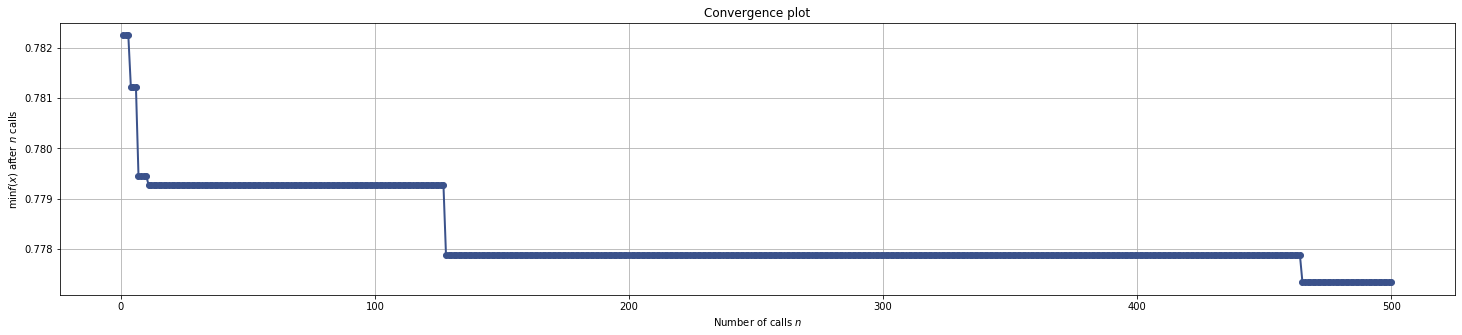

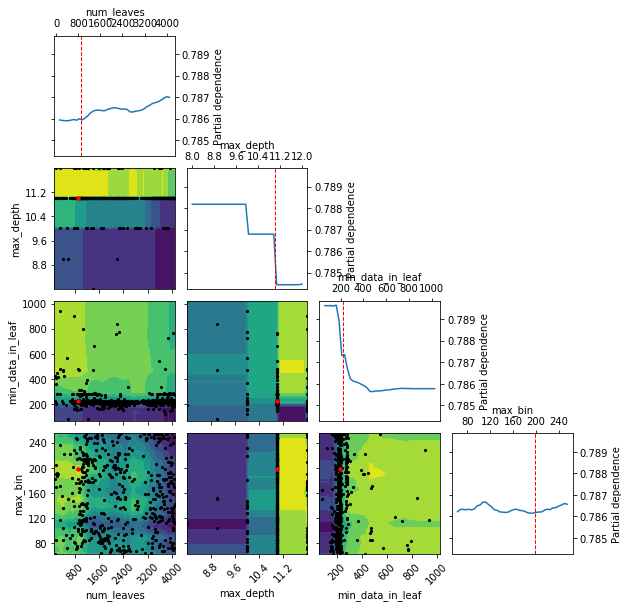

In [56]:
res = load(r'output/data/HPO_LGBM_result.pkl')
print('Best params:', res.x)
plot_convergence(res)
plot_objective(res)

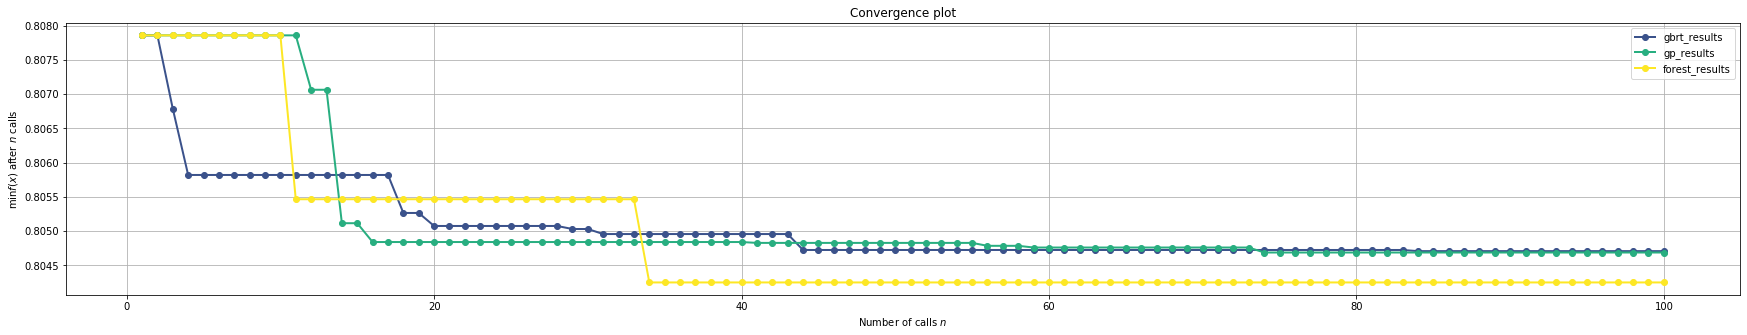

Best score: rmse_val= 0.804709587191561 Best parameters: [12267, 24, 508, 3882]


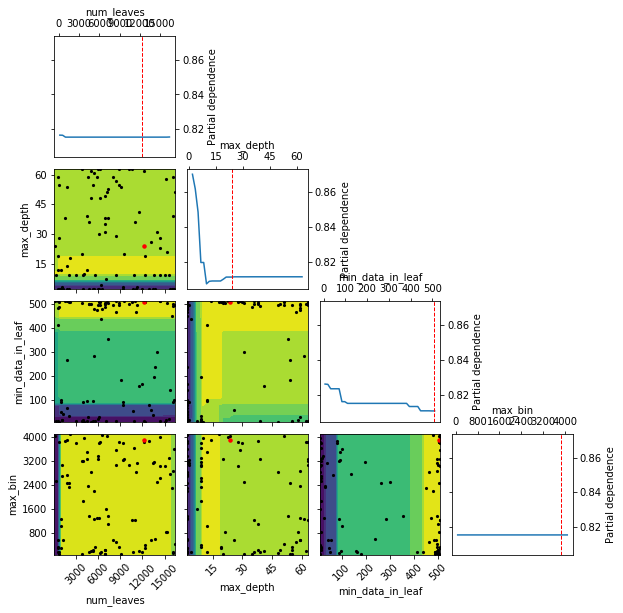

Best score: rmse_val= 0.8046892127047138 Best parameters: [802, 29, 508, 2813]


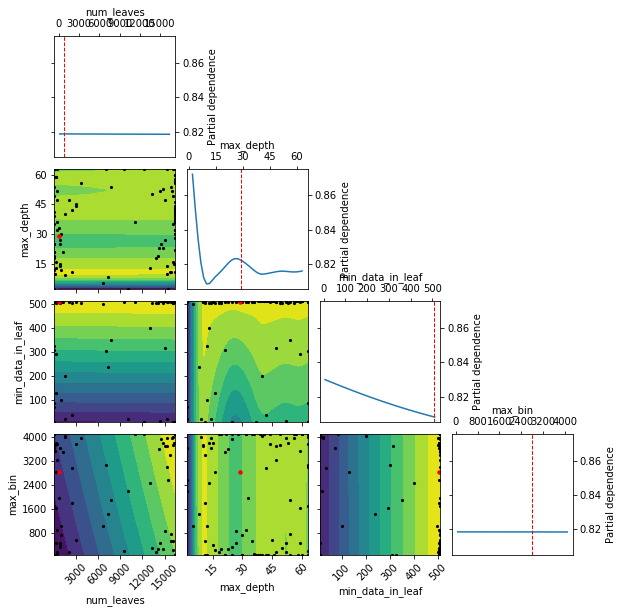

Best score: rmse_val= 0.8042525384529841 Best parameters: [4367, 10, 498, 945]


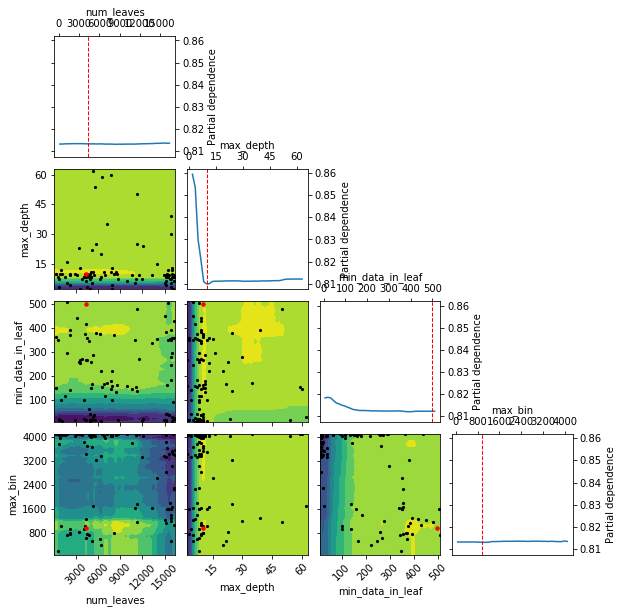

In [38]:
#  Now plot the results
res_gbrt = load( r'output/HPO_minimization_gbrt_result.pkl')
res_gp = load( r'output/HPO_minimization_gp_result.pkl')
res_forest = load( r'output/HPO_minimization_forest_result.pkl')

results = [('gbrt_results', res_gbrt), ('gp_results', res_gp), ('forest_results', res_forest)] # put results together for plotting
plot_convergence(*results)
plt.show()

for res in (res_gbrt, res_gp, res_forest): # Plot pairwise search_space for minimization function      
    print('Best score:', 'rmse_val=', res.fun, 'Best parameters:', res.x)
    plot_objective(res) #plot_convergence(res) # Can also be shown, but plot_objective is more informative 
    plt.show()
    #plot_evaluations(res) - to plot progress 

As we see, in this particular case, forest_minimize did the job much quicker and much more accuratly. Forest was also shown to outperform gp and gbrt in https://neptune.ml/blog/scikit-optimize.
Somehow, the gp_minimize and gbrt were not able to find a minimum for max_depth (which is visible on all plots). Also, no visible dependence on max_bin is seen for gp and gbrt, while seen for forest. 
One can also notice that the learning is much more step-wize for forest, while gp and gbrt shows slower but constant progress...

I guess, that for low number of n_calls (e.g. 100) forest_minimize might be a better strategy for byasian optimization, it is probable, that for high number of n_calls gbrt would on the opposite show better results....
Forest is buid from strong learners - fully grown decision trees (low bias, high variance). It tackles the error reduction task by reducing variance. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias (which is slightly higher than the bias of an individual tree in the forest). Hence the need for large, unpruned trees, so that the bias is initially as low as possible. The gbrt boosting is build from an ensemble week learners (high bias, low variance). Boosting reduces error mainly by reducing bias (and also to some extent variance, by aggregating the output from many models). 

Best params: [1417, 10, 469, 97]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E1A3FEC518>,
      dtype=object)

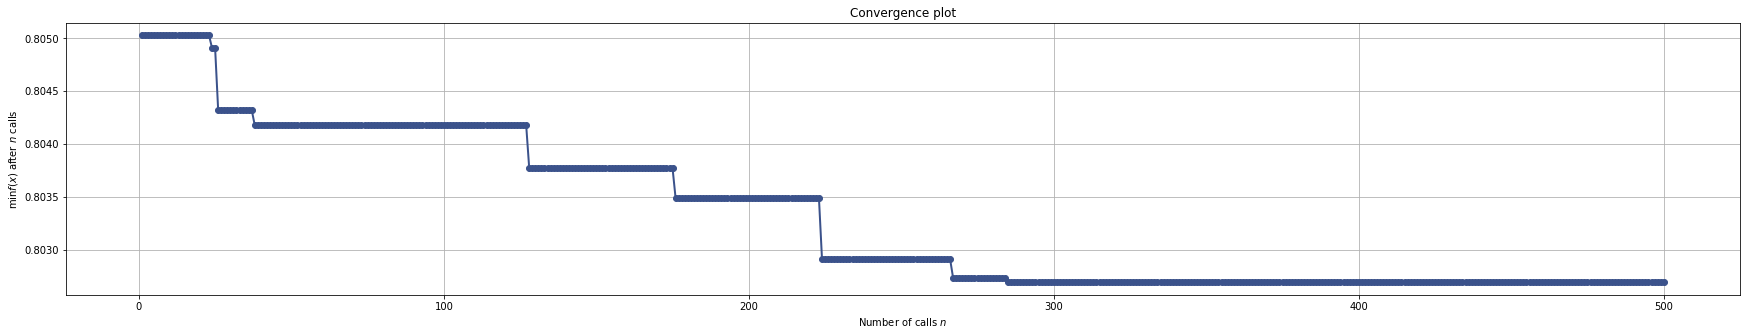

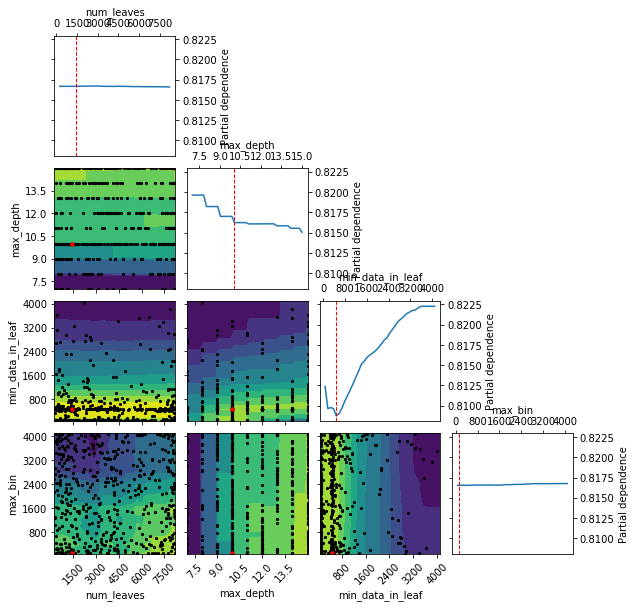

In [39]:
res = load(r'output/HPO_LGBM_result.pkl')
print('Best params:', res.x)
plot_convergence(res)
plot_objective(res)

In [57]:
#Take the best found parameters
best_dynamic_params = dict(zip(['num_leaves', 'max_depth', 'min_data_in_leaf', 'max_bin'], res.x))
params = {**best_dynamic_params, **static_params}

In [58]:
params

{'num_leaves': 907,
 'max_depth': 11,
 'min_data_in_leaf': 225,
 'max_bin': 199,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting': 'gbdt',
 'num_threads': 8,
 'learning_rate': 0.1,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'feature_fraction': 0.5,
 'save_binary': True}

## Now run best parameters with increased num_boost_rounds, decrease learning rate

In [59]:
# Define run LGBM function
def LGBM(num_boost_round, learning_rate, early_stopping_rounds, boosting):
    
    params['learning_rate'] = learning_rate
    params['boosting'] = boosting
    
    evals_result = {}  # to record eval results for plotting

    model = lgb.train(params,
                      lgb_train_data, 
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train_data, lgb_val_data],
                      valid_names=['train','val'],
                      early_stopping_rounds=early_stopping_rounds,
                      evals_result=evals_result,                      
                      verbose_eval=500)
    
    y_pred_test = model.predict(X_test, num_iteration=model.best_iteration).clip(0,20) # Competition evaluation requirement: True target values are clipped into [0,20] range
    
    RMSE_train = evals_result['train']['rmse']
    RMSE_val = evals_result['val']['rmse'] 
      
#________________________________________________________________________________________
# Plotting results
    plt.plot(evals_result['train']['rmse'], 'g', label='train')
    plt.plot(evals_result['val']['rmse'], 'r', label='val')
    plt.legend(loc = 'upper right')
    plt.grid(True)
    plt.show()
  
    return y_pred_test, RMSE_train, RMSE_val

Training until validation scores don't improve for 500 rounds
[500]	train's rmse: 0.787161	val's rmse: 0.784804
[1000]	train's rmse: 0.763857	val's rmse: 0.781279
[1500]	train's rmse: 0.749158	val's rmse: 0.779687
[2000]	train's rmse: 0.738146	val's rmse: 0.778032
[2500]	train's rmse: 0.72969	val's rmse: 0.777836
[3000]	train's rmse: 0.721665	val's rmse: 0.777631
[3500]	train's rmse: 0.71479	val's rmse: 0.777377
Early stopping, best iteration is:
[3391]	train's rmse: 0.716329	val's rmse: 0.777083


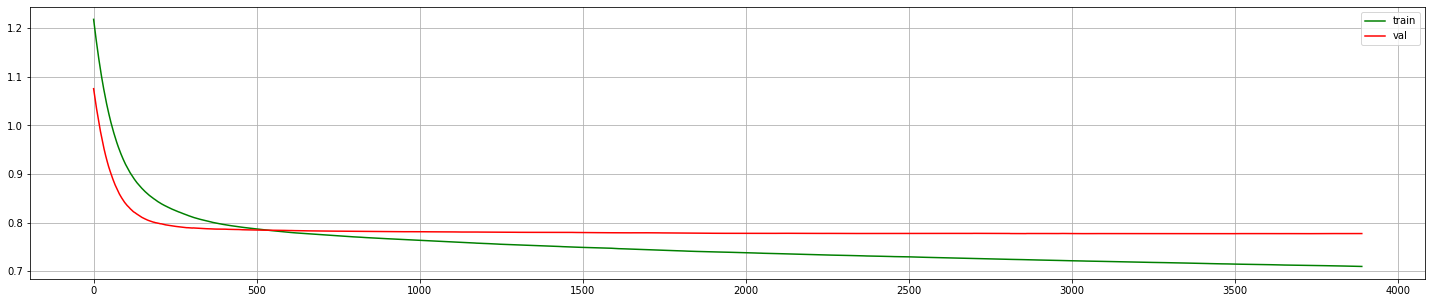

Wall time: 41min 57s


In [45]:
%%time
y_pred_test, RMSE_train, RMSE_val = LGBM(num_boost_round = 10000, learning_rate  = 0.01, early_stopping_rounds = 500, boosting = 'gbdt')

Training until validation scores don't improve for 1000 rounds
[500]	train's rmse: 0.786105	val's rmse: 0.781948
[1000]	train's rmse: 0.762256	val's rmse: 0.775933
[1500]	train's rmse: 0.748487	val's rmse: 0.77399
[2000]	train's rmse: 0.73822	val's rmse: 0.772551
[2500]	train's rmse: 0.729228	val's rmse: 0.772423
[3000]	train's rmse: 0.722239	val's rmse: 0.772196
[3500]	train's rmse: 0.715286	val's rmse: 0.77223
[4000]	train's rmse: 0.708778	val's rmse: 0.771878
[4500]	train's rmse: 0.703505	val's rmse: 0.771791
[5000]	train's rmse: 0.698592	val's rmse: 0.772305
Early stopping, best iteration is:
[4365]	train's rmse: 0.704759	val's rmse: 0.771642


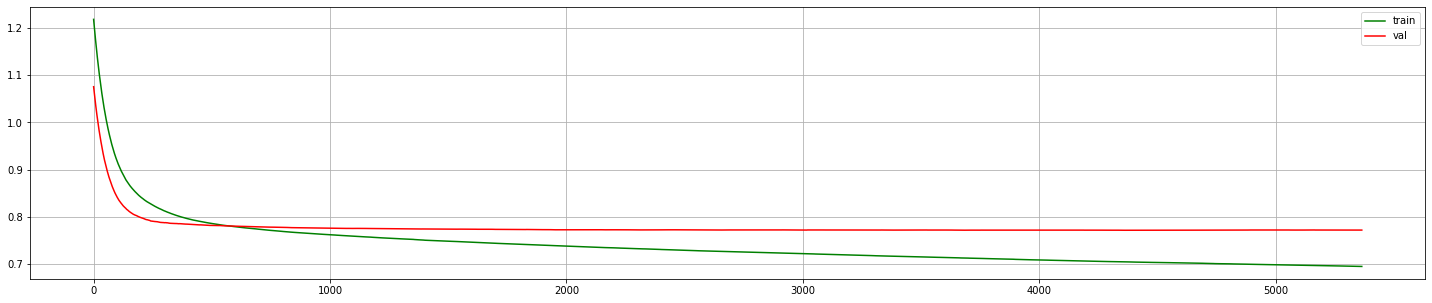

Wall time: 59min 23s


In [62]:
%%time
y_pred_test, RMSE_train, RMSE_val = LGBM(num_boost_round = 10000, learning_rate  = 0.01, early_stopping_rounds = 1000, boosting = 'gbdt')

In [63]:
submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': y_pred_test})
submission.to_csv(r'output/submissions/lgbm_HPO_submission_DL.csv', index=False)

In [ ]:
LB score: 0.90742

Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 0.985737	val's rmse: 0.918942
[1000]	train's rmse: 0.89325	val's rmse: 0.851178
[1500]	train's rmse: 0.849943	val's rmse: 0.825918
[2000]	train's rmse: 0.827254	val's rmse: 0.815067
[2500]	train's rmse: 0.813744	val's rmse: 0.810358
[3000]	train's rmse: 0.803942	val's rmse: 0.807513
Early stopping, best iteration is:
[3140]	train's rmse: 0.801815	val's rmse: 0.807246


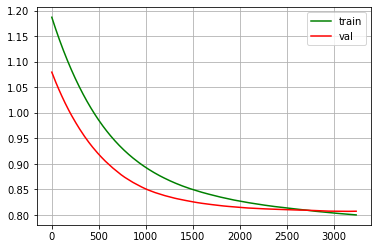

Wall time: 49min 29s


In [74]:
%%time
# Let us check how the result will change if we use all features and no bagging
params['bagging_fraction'] = 1
params['feature_fraction'] = 1

y_pred_test1, RMSE_train1, RMSE_val1 = LGBM(num_boost_round = 10000, learning_rate  = 0.001, early_stopping_rounds = 100, boosting = 'gbdt')

## Now try 'dart' boosting

%time LGBM(num_boost_round = 1000, learning_rate  = 0.01, early_stopping_rounds = 10, boosting = 'gbdt')

%time LGBM(num_boost_round = 1000, learning_rate  = 0.01, early_stopping_rounds = 10, boosting = 'dart')

Dart boosting did a worse job (for lower learning rate as well), its learing curve is irregular, and it is so much more slower - tens of  times!  Use gbdt.

### XGB

In [74]:
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [78]:
# Define the CatBoost search space (dynamic parameters)
search_space_xgb  = [Integer(6, 12, name='max_depth'),
                     Integer(0, 1000, name='min_child_weight'),
                     Real(0, 100, name='gamma'),
                     Real(0, 1, name='colsample_bytree')]

static_params_xgb = {'learning_rate': 0.2,
                     'n_estimators': 100,
                     'subsample': 0.5,
                     'objective': 'reg:squarederror',
                     'tree_method': 'approx',
                     'n_jobs': 8,
                     'random_state': 42}          

In [79]:
# Define a function to minimize - the function should return the value to minimize by gp_minimize function
@skopt.utils.use_named_args(search_space_xgb) # This decorator ( @ ) allows the objective function to receive the parameters as keyword arguments
def objective(**dynamic_params_xgb): # n_call is used to monitor minimization progress
    
    print('Solving for:', dynamic_params_xgb)
 
    model =  XGBRegressor(**static_params_xgb, **dynamic_params_xgb)

    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose = False,
              early_stopping_rounds = 5)        
     
    y_pred_val = model.predict(X_val).clip(0,20)
    rmse_val = np.sqrt(mean_squared_error(y_pred_val, y_val))

    return rmse_val

In [ ]:
%%time
res_xgb = forest_minimize(objective, search_space, n_calls=100, x0=None, callback=[checkpoint_callback], random_state=42)
dump(res_xgb, r'output/HPO_xgb_minimization_result.pkl')

#xgb_params['learing_rate'] = 0.01
#rmse_val= 0.8058033 Best parameters: [10, 0, 4.311568830991819, 0.24198586492878643]

rmse_val= 0.8058033 Best parameters: [10, 0, 4.311568830991819, 0.24198586492878643]


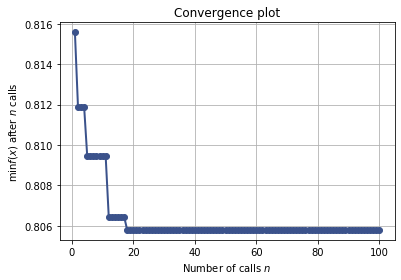

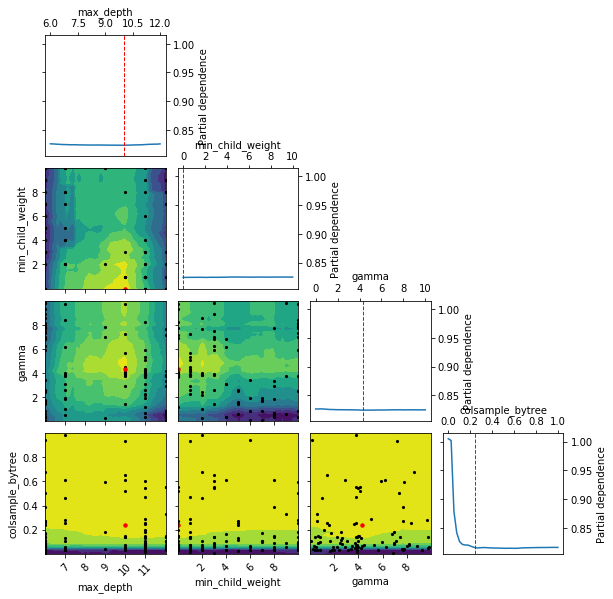

In [81]:
res_xgb = load(r'output/HPO_xgb_minimization_result.pkl')
print('rmse_val=', res_xgb.fun, 'Best parameters:', res_xgb.x)
plot_convergence(res_xgb)
plot_objective(res_xgb)
plt.show()

In [94]:
# Take the best found parameters for xgb
dynamic_params_best_xgb = dict(zip(['max_depth', 'min_child_weight', 'gamma', 'colsample_bytree'], res_xgb.x))
xgb_params = {**dynamic_params_best_xgb, **static_params_xgb}

In [98]:
%%time
#Now decrease the learning_rate=0.01 and use bigger early_stopping=10 to find the optimum
xgb_params['learning_rate'] = 0.01
xgb_params['n_estimators'] = 1000
print(xgb_params)

model =  XGBRegressor(**xgb_params)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          verbose = 100,
          early_stopping_rounds = 20)        
     
y_pred_val_xgb = model.predict(X_val).clip(0,20)
rmse_val_xgb = np.sqrt(mean_squared_error(y_pred_val, y_val))
print('RMSE_val_xgb:', rmse_val_xgb)

{'max_depth': 10, 'min_child_weight': 0, 'gamma': 4.311568830991819, 'colsample_bytree': 0.24198586492878643, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.5, 'objective': 'reg:squarederror', 'tree_method': 'approx', 'n_jobs': 8, 'random_state': 42}
[0]	validation_0-rmse:1.20178	validation_1-rmse:1.10215
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[100]	validation_0-rmse:0.938198	validation_1-rmse:0.886194
[200]	validation_0-rmse:0.851891	validation_1-rmse:0.827448
[300]	validation_0-rmse:0.81722	validation_1-rmse:0.810555
[400]	validation_0-rmse:0.798442	validation_1-rmse:0.806591
Stopping. Best iteration:
[474]	validation_0-rmse:0.787393	validation_1-rmse:0.804435

RMSE_val_xgb: 0.8058033
Wall time: 1h 4min 26s


In [99]:
y_pred_test_xgb = model.predict(X_test).clip(0,20)

pickle.dump(model, open(r'output/xgb_model.pkl', 'wb')) #save best trained model

pickle.dump(y_pred_val_xgb, open(r'3. HPO/xgb_val.pkl', 'wb')) #save val_predictions
pickle.dump(y_pred_test_xgb, open(r'3. HPO/xgb_test.pkl', 'wb')) # save test_predictions for ensemble

In [100]:
# Create submission file
submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': y_pred_test})
submission.to_csv(r'output/xgb_HPO_submission.csv', index=False)

In [101]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Early stopping rounds = 5 to avoid very long run for XGB
def run_xgb(X_train, y_train, X_val, y_val, X_test):

    model = XGBRegressor(n_estimators=1000,
                         colsample_bytree=0.8,
                         subsample=0.8,
                         eta=0.3,
                         seed=42)
    model.fit(X_train,
              y_train,
              eval_metric="rmse",
              eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose=True,
              early_stopping_rounds = 10)
    
    y_pred_train = model.predict(X_train).clip(0,20)
    y_pred_val = model.predict(X_val).clip(0,20)
    y_pred_test = model.predict(X_test).clip(0,20)

    print(f"XGB: RMSE train: {rmse(y_train, y_pred_train)} RMSE val: {rmse(y_val, y_pred_val)}")
    return y_pred_val, y_pred_test, model

In [102]:
%%time
y_pred_val_xgb, y_pred_test_xgb, xgb_model = run_xgb(X_train, y_train, X_val, y_val, X_test)

pickle.dump(xgb_model, open(r'output/xgb_model.pkl', 'wb')) # Save trained model to file
#pickle.dump(y_pred_val_xgb, open(r'3. HPO/xgb_val.pkl', 'wb')) # save predictions for an ensemble
#pickle.dump(y_pred_test_xgb, open(r'3. HPO/xgb_test.pkl', 'wb')) # save predictions for an ensemble

submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': y_pred_test_xgb})
submission.to_csv(r'output/xgb_submission.csv', index=False)

C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:00:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:27] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.13502	validation_1-rmse:1.07032
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.09959	validation_1-rmse:1.04007
[2]	validation_0-rmse:1.07675	validation_1-rmse:1.0141
[3]	validation_0-rmse:1.05546	validation_1-rmse:0.993451
[4]	validation_0-rmse:1.01675	validation_1-rmse:0.975909
[5]	validation_0-rmse:1.00134	validation_1-rmse:0.960171
[6]	validation_0-rmse:0.987717	validation_1-rmse:0.947622
[7]	validation_0-rmse:0.976719

50 min
XGB: RMSE train: 0.808 RMSE val: 0.809
0.91554

### CatBoost

In [46]:
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

In [5]:
# Define the CatBoost search space (dynamic parameters)
search_space  = [Integer(6, 10, name='depth'),
                 Integer(1, 10, name='l2_leaf_reg'),
                 Real(0, 1, name='bagging_temperature'),
                 Real(0, 1, name='random_strength')]

#search_space = [           
#                 'depth': Integer(1, 8),
#                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
#                 'random_strength': Real(1e-9, 10, 'log-uniform'),
#                 'bagging_temperature': Real(0.0, 1.0),
#                 'border_count': Integer(1, 255),
#                 'ctr_border_count': Integer(1, 255),
#                 'l2_leaf_reg': Integer(2, 30),
#                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

#                 Real(0.0001, 10000,prior ='log-uniform', name='random_strength'),
#                 Real(0.0001, 10000,prior ='log-uniform', name='bagging_temperature')]
#Real(0.0001, 10000,prior ='log-uniform', name='l2_leaf_reg'),
# Define lgb static parameters
'''static_params = {'eval_metric': 'RMSE',
                 'random_seed': 42,
                 'od_type': 'Iter',
                 'od_wait': 20}     '''          

"static_params = {'eval_metric': 'RMSE',\n                 'random_seed': 42,\n                 'od_type': 'Iter',\n                 'od_wait': 20}     "

In [16]:
# Define a function to minimize - the function should return the value to minimize by gp_minimize function
@skopt.utils.use_named_args(search_space) # This decorator ( @ ) allows the objective function to receive the parameters as keyword arguments
def objective(**dynamic_params): # n_call is used to monitor minimization progress
    
    print(dynamic_params)
    
    #params = {**dynamic_params} # merge the two dictionaries
 
    model = CatBoostRegressor(iterations = 100,
                              **dynamic_params)

    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=False,
              plot = True)
    
    y_pred_val = model.predict(X_val).clip(0,20)
    rmse_val = np.sqrt(mean_squared_error(y_pred_val, y_val))

    return rmse_val

In [ ]:
%%time
res_cat = forest_minimize(objective, search_space, n_calls=10, x0=None, callback=[checkpoint_callback], random_state=42)

In [ ]:
dump(res_cat, r'output/HPO_cat_minimization_result.pkl')

In [ ]:
res_cat = load(r'output/HPO_cat_minimization_result.pkl')
print('Best score for cat_minimize', 'rmse_val=', res_cat.fun, 'Best parameters:', res_cat.x)
plot_convergence(res_cat)
plot_objective(res_cat)
plt.show()

## Now decrease the learning rate and increase iterations

In [52]:
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    
    model = CatBoostRegressor()
                              
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=True,
              plot = False)
    
    y_pred_train = model.predict(X_train).clip(0,20)
    y_pred_val = model.predict(X_val).clip(0,20)
    y_pred_test = model.predict(X_test).clip(0,20)

    print(f"CatB: RMSE train: {rmse(y_train, y_pred_train)} RMSE val: {rmse(y_val, y_pred_val)}")
    return y_pred_val, y_pred_test, model

In [56]:
import catboost
catboost.__version__

'0.20.2'

In [ ]:
%%time
y_pred_val_cat, y_pred_test_cat, cat_model = run_catboost(X_train, y_train, X_val, y_val,  X_test)

In [ ]:
pickle.dump(cat_model, open(r'output/cat_model.pkl', 'wb')) # Save trained model to file
#pickle.dump(y_pred_val_cat, open(r'3. HPO/cat_val.pkl', 'wb')) # save predictions for an ensemble
#pickle.dump(y_pred_test_cat, open(r'3. HPO/cat_test.pkl', 'wb')) # save predictions for an ensemble

submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': y_pred_test_cat})
submission.to_csv(r'output/cat_submission.csv', index=False)

22 min
Train, val, test: 0.784, 0.803, 0.9106

### Neural Nets

In [68]:
# Data preparation for NN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_ss = scaler.transform(X_train)
X_val_ss   = scaler.transform(X_val)
X_test_ss  = scaler.transform(X_test)

In [69]:
from sklearn.neural_network import MLPRegressor

def run_nn(X_train_ss, y_train, X_val_ss, y_val, X_test_ss):
    
    model = MLPRegressor(hidden_layer_sizes=(128,64,),
                         verbose = True,
                         early_stopping=True,
                         n_iter_no_change=5,
                         max_iter=2000,
                         tol=1e-3,
                         random_state=42)

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train).clip(0,20)
    y_pred_val = model.predict(X_val).clip(0,20)
    y_pred_test = model.predict(X_test).clip(0,20)

    print(f"CatB: RMSE train: {rmse(y_train, y_pred_train)} RMSE val: {rmse(y_val, y_pred_val)}")
    return y_pred_val, y_pred_test, model

In [70]:
%%time
y_pred_val_nn, y_pred_test_nn, nn_model = run_nn(X_train, y_train, X_val, y_val,  X_test)

pickle.dump(nn_model, open(r'output/nn_model.pkl', 'wb')) # Save trained model to file
#pickle.dump(y_pred_val_nn, open(r'3. HPO/nn_val.pkl', 'wb')) # save predictions for an ensemble
#pickle.dump(y_pred_test_nn, open(r'3. HPO/nn_test.pkl', 'wb')) # save predictions for an ensemble

submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': y_pred_test_nn})
submission.to_csv(r'output/nn_submission.csv', index=False)

Iteration 1, loss = 69.51718385
Validation score: -0.262274
Iteration 2, loss = 1.48691969
Validation score: -2.475130
Iteration 3, loss = 0.48201879
Validation score: 0.388669
Iteration 4, loss = 0.43356427
Validation score: 0.403688
Iteration 5, loss = 0.42681400
Validation score: 0.402341
Iteration 6, loss = 0.42044363
Validation score: 0.411576
Iteration 7, loss = 0.41775158
Validation score: 0.379095
Iteration 8, loss = 0.41550780
Validation score: 0.418281
Iteration 9, loss = 0.41341292
Validation score: 0.426707
Iteration 10, loss = 0.41097690
Validation score: 0.424656
Iteration 11, loss = 0.40968360
Validation score: 0.429120
Iteration 12, loss = 0.40822947
Validation score: 0.435338
Iteration 13, loss = 0.40751086
Validation score: 0.439075
Iteration 14, loss = 0.40677728
Validation score: 0.416302
Iteration 15, loss = 0.40613413
Validation score: 0.413801
Iteration 16, loss = 0.40508322
Validation score: 0.435547
Iteration 17, loss = 0.40423213
Validation score: 0.437580
Ite

1h 22min hidden layers = 128,64, . : 0.891 0.861 